In [1]:
'''
written by Lorenz Muller
'''

import numpy as np
import tensorflow as tf
from time import time
import sys
from dataLoader import loadData
import os

In [2]:
seed = 47
np.random.seed(seed)

In [3]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 5.004207611083984 seconds
loaded dense data matrix


In [6]:
# tr_1 = tr.copy()
# vr_1 = vr.copy()

In [7]:
# (vr_1 > 0).sum(), (tr_1 > 0).sum() 

In [8]:
# np.save('./tr', tr_1)
# np.save('./vr', vr_1)

In [9]:
tr_2 = np.load('./tr.npy')
vr_2 = np.load('./vr.npy')

In [10]:
(tr_2 == tr).all(), (vr_2 == vr).all()

(True, True)

In [11]:
del tr_2
del vr_2

In [12]:
# np.random.seed(seed)
# path = './ml-1m/ratings.dat'
# delimiter='::'

# tic = time()
# print('reading data...')
# data = np.loadtxt(path, skiprows=0, delimiter=delimiter).astype('int32')
# print('data read in', time() - tic, 'seconds')

# n_u = np.unique(data[:, 0]).shape[0]  # number of users
# n_m = np.unique(data[:, 1]).shape[0]  # number of movies
# n_r = data.shape[0]  # number of ratings

# # these dictionaries define a mapping from user/movie id to to user/movie number (contiguous from zero)
# udict = {}
# for i, u in enumerate(np.unique(data[:, 0]).tolist()):
#     udict[u] = i
# mdict = {}
# for i, m in enumerate(np.unique(data[:, 1]).tolist()):
#     mdict[m] = i

# # shuffle indices
# idx = np.arange(n_r)
# np.random.shuffle(idx)

# trainRatings = np.zeros((n_u, n_m), dtype='float32')
# validRatings = np.zeros((n_u, n_m), dtype='float32')

In [13]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# import pandas as pd 

# ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
# users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
# movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r').readlines()]

# ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
# movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
# movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [16]:
# R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
# R_df.head()

In [17]:
# ratings = np.array(R_df.values, dtype=int)
# n_users = ratings.shape[0]
# n_items = ratings.shape[1]

In [18]:
# t = tr + vr

In [19]:
tr.shape, vr.shape

((6040, 3706), (6040, 3706))

In [20]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [21]:
get_sparsity(tr)

4.021525859265269

In [22]:
get_sparsity(vr)

0.44683670296601535

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os
# from tensorboard_logger import configure, log_value

In [27]:
lrD = 5e-4
lrG = 5e-4
batch_size = 100
cuda = True
epochs = 1000 #change
device = 5
seed = 1
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-3 # constant for L2 penalty (diversity)
name = "mnist-experiment"
# configure("runs/run-" + args.name, flush_secs=5)
torch.manual_seed(seed)


# data_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#     transform=transforms.Compose([
#     transforms.ToTensor(),
#     ])), batch_size=batch_size, shuffle=True)

In [28]:
train = tr.copy()

In [29]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())/(fake == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD(use_cuda=True)
netG = NetG()
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [30]:
# netD.load_state_dict(torch.load('./netD-1m'))
# netG.load_state_dict(torch.load('./netG-1m'))

In [31]:
one = torch.FloatTensor([1])
mone = one * -1
cuda = True
if cuda is True:
    netD.cuda()
    netG.cuda()
    one, mone = one.cuda(), mone.cuda()

In [32]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [33]:
def getRealSample(length=6):
     return Variable(torch.IntTensor(np.random.choice([0, 1], size=(batch_size, length))))

In [34]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [35]:
get_random_batch(train, batch_size=batch_size).shape

(100, 3706)

In [36]:
train = torch.autograd.Variable(torch.Tensor(train))

In [37]:
def d_my(x_r, x_g):
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [38]:
train.shape

torch.Size([6040, 3706])

In [39]:
# import pandas as pd 

# ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
# users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
# movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r').readlines()]

# ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
# movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
# movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

# R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

# ratings = np.array(R_df.values, dtype=int)
# n_users = ratings.shape[0]
# n_items = ratings.shape[1]

In [40]:
# ratings

In [41]:
# get_sparsity(ratings)

In [42]:
get_sparsity(tr)

4.021525859265269

In [43]:
get_sparsity(vr)

0.44683670296601535

In [44]:
real[1,:20]

NameError: name 'real' is not defined

In [45]:
# real[1,:20] + (fake[1,:20] * ((real[1,:20] != 0).float()))
real[1,:20] + fake[1,:20]* (real[1,:20] == 0).float()

NameError: name 'real' is not defined

In [46]:
(fake[1,:20] * ((real[1,:20] != 0).float()))

NameError: name 'fake' is not defined

In [47]:
fake = fake[:100, :]

NameError: name 'fake' is not defined

In [48]:
# fake.type(), real.type()

In [49]:
# (fake * ((real != 0).float()))

In [50]:
# real
# # fake = fake * Variable(real != 0).float().cuda()

In [51]:
# fake

In [383]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
for epoch in range(epochs):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

Epoch number 1. my distance between random real and fake samples 30490.83203125
Epoch number 1. MSE distance between random real and fake samples 0.29879799485206604
Epoch number 3. my distance between random real and fake samples 41031.34375
Epoch number 3. MSE distance between random real and fake samples 0.39401862025260925
Epoch number 5. my distance between random real and fake samples 34724.3359375
Epoch number 5. MSE distance between random real and fake samples 0.33573490381240845
Epoch number 7. my distance between random real and fake samples 36062.71875
Epoch number 7. MSE distance between random real and fake samples 0.35354113578796387
Epoch number 9. my distance between random real and fake samples 41684.0546875
Epoch number 9. MSE distance between random real and fake samples 0.3983769416809082
Epoch number 11. my distance between random real and fake samples 35929.921875
Epoch number 11. MSE distance between random real and fake samples 0.3460485637187958
Epoch number 1

Epoch number 99. my distance between random real and fake samples 35254.609375
Epoch number 99. MSE distance between random real and fake samples 0.3350379765033722
Epoch number 101. my distance between random real and fake samples 34184.23828125
Epoch number 101. MSE distance between random real and fake samples 0.3319316506385803
Epoch number 103. my distance between random real and fake samples 36081.421875
Epoch number 103. MSE distance between random real and fake samples 0.3446906507015228
Epoch number 105. my distance between random real and fake samples 37437.671875
Epoch number 105. MSE distance between random real and fake samples 0.35950973629951477
Epoch number 107. my distance between random real and fake samples 46220.1328125
Epoch number 107. MSE distance between random real and fake samples 0.4566962718963623
Epoch number 109. my distance between random real and fake samples 46585.3828125
Epoch number 109. MSE distance between random real and fake samples 0.449697017669

Epoch number 195. MSE distance between random real and fake samples 0.43550172448158264
Epoch number 197. my distance between random real and fake samples 42006.21484375
Epoch number 197. MSE distance between random real and fake samples 0.39960578083992004
Epoch number 199. my distance between random real and fake samples 31970.09765625
Epoch number 199. MSE distance between random real and fake samples 0.30986618995666504
Epoch number 201. my distance between random real and fake samples 37655.6171875
Epoch number 201. MSE distance between random real and fake samples 0.36410096287727356
Epoch number 203. my distance between random real and fake samples 45243.67578125
Epoch number 203. MSE distance between random real and fake samples 0.43759220838546753
Epoch number 205. my distance between random real and fake samples 42947.359375
Epoch number 205. MSE distance between random real and fake samples 0.4145495593547821
Epoch number 207. my distance between random real and fake samples

Epoch number 293. my distance between random real and fake samples 36289.06640625
Epoch number 293. MSE distance between random real and fake samples 0.36039799451828003
Epoch number 295. my distance between random real and fake samples 39519.5546875
Epoch number 295. MSE distance between random real and fake samples 0.3748885989189148
Epoch number 297. my distance between random real and fake samples 42058.3515625
Epoch number 297. MSE distance between random real and fake samples 0.4064984619617462
Epoch number 299. my distance between random real and fake samples 39804.7734375
Epoch number 299. MSE distance between random real and fake samples 0.37555548548698425
Epoch number 301. my distance between random real and fake samples 30905.21875
Epoch number 301. MSE distance between random real and fake samples 0.29429003596305847
Epoch number 303. my distance between random real and fake samples 35796.1640625
Epoch number 303. MSE distance between random real and fake samples 0.3502570

Epoch number 389. MSE distance between random real and fake samples 0.3701592981815338
Epoch number 391. my distance between random real and fake samples 48896.625
Epoch number 391. MSE distance between random real and fake samples 0.4645906090736389
Epoch number 393. my distance between random real and fake samples 36071.78125
Epoch number 393. MSE distance between random real and fake samples 0.35312896966934204
Epoch number 395. my distance between random real and fake samples 37955.9296875
Epoch number 395. MSE distance between random real and fake samples 0.36549460887908936
Epoch number 397. my distance between random real and fake samples 38492.8515625
Epoch number 397. MSE distance between random real and fake samples 0.37894800305366516
Epoch number 399. my distance between random real and fake samples 38120.20703125
Epoch number 399. MSE distance between random real and fake samples 0.3677344024181366
Epoch number 401. my distance between random real and fake samples 40662.89

Epoch number 487. my distance between random real and fake samples 35782.18359375
Epoch number 487. MSE distance between random real and fake samples 0.3416317403316498
Epoch number 489. my distance between random real and fake samples 39111.7265625
Epoch number 489. MSE distance between random real and fake samples 0.3774130642414093
Epoch number 491. my distance between random real and fake samples 42902.0859375
Epoch number 491. MSE distance between random real and fake samples 0.4133308231830597
Epoch number 493. my distance between random real and fake samples 43424.6328125
Epoch number 493. MSE distance between random real and fake samples 0.4062785804271698
Epoch number 495. my distance between random real and fake samples 36645.2109375
Epoch number 495. MSE distance between random real and fake samples 0.3537876605987549
Epoch number 497. my distance between random real and fake samples 49420.5390625
Epoch number 497. MSE distance between random real and fake samples 0.46727773

Epoch number 583. MSE distance between random real and fake samples 0.3665417432785034
Epoch number 585. my distance between random real and fake samples 39345.51171875
Epoch number 585. MSE distance between random real and fake samples 0.3750907778739929
Epoch number 587. my distance between random real and fake samples 35746.296875
Epoch number 587. MSE distance between random real and fake samples 0.34427767992019653
Epoch number 589. my distance between random real and fake samples 33646.3203125
Epoch number 589. MSE distance between random real and fake samples 0.32478389143943787
Epoch number 591. my distance between random real and fake samples 44672.0859375
Epoch number 591. MSE distance between random real and fake samples 0.4299521744251251
Epoch number 593. my distance between random real and fake samples 33217.51171875
Epoch number 593. MSE distance between random real and fake samples 0.31621626019477844
Epoch number 595. my distance between random real and fake samples 38

Epoch number 681. my distance between random real and fake samples 34736.9140625
Epoch number 681. MSE distance between random real and fake samples 0.3389429748058319
Epoch number 683. my distance between random real and fake samples 40959.109375
Epoch number 683. MSE distance between random real and fake samples 0.39568617939949036
Epoch number 685. my distance between random real and fake samples 31351.1953125
Epoch number 685. MSE distance between random real and fake samples 0.2988829016685486
Epoch number 687. my distance between random real and fake samples 37079.32421875
Epoch number 687. MSE distance between random real and fake samples 0.3623746633529663
Epoch number 689. my distance between random real and fake samples 33528.79296875
Epoch number 689. MSE distance between random real and fake samples 0.31683892011642456
Epoch number 691. my distance between random real and fake samples 37603.65625
Epoch number 691. MSE distance between random real and fake samples 0.38228213

Epoch number 777. MSE distance between random real and fake samples 0.37689921259880066
Epoch number 779. my distance between random real and fake samples 36349.734375
Epoch number 779. MSE distance between random real and fake samples 0.3506777882575989
Epoch number 781. my distance between random real and fake samples 37089.20703125
Epoch number 781. MSE distance between random real and fake samples 0.3582298457622528
Epoch number 783. my distance between random real and fake samples 38731.34375
Epoch number 783. MSE distance between random real and fake samples 0.37313908338546753
Epoch number 785. my distance between random real and fake samples 38854.0390625
Epoch number 785. MSE distance between random real and fake samples 0.38149482011795044
Epoch number 787. my distance between random real and fake samples 31315.470703125
Epoch number 787. MSE distance between random real and fake samples 0.3008478581905365
Epoch number 789. my distance between random real and fake samples 406

Epoch number 875. my distance between random real and fake samples 45568.76171875
Epoch number 875. MSE distance between random real and fake samples 0.4274243712425232
Epoch number 877. my distance between random real and fake samples 36822.5078125
Epoch number 877. MSE distance between random real and fake samples 0.3602216839790344
Epoch number 879. my distance between random real and fake samples 39838.8671875
Epoch number 879. MSE distance between random real and fake samples 0.3790971636772156
Epoch number 881. my distance between random real and fake samples 44668.3515625
Epoch number 881. MSE distance between random real and fake samples 0.43487903475761414
Epoch number 883. my distance between random real and fake samples 42613.87890625
Epoch number 883. MSE distance between random real and fake samples 0.41438886523246765
Epoch number 885. my distance between random real and fake samples 34694.60546875
Epoch number 885. MSE distance between random real and fake samples 0.3402

Epoch number 971. MSE distance between random real and fake samples 0.39706045389175415
Epoch number 973. my distance between random real and fake samples 36773.52734375
Epoch number 973. MSE distance between random real and fake samples 0.3529961109161377
Epoch number 975. my distance between random real and fake samples 35207.6015625
Epoch number 975. MSE distance between random real and fake samples 0.33127766847610474
Epoch number 977. my distance between random real and fake samples 34847.0859375
Epoch number 977. MSE distance between random real and fake samples 0.33463242650032043
Epoch number 979. my distance between random real and fake samples 37086.10546875
Epoch number 979. MSE distance between random real and fake samples 0.36316952109336853
Epoch number 981. my distance between random real and fake samples 34486.38671875
Epoch number 981. MSE distance between random real and fake samples 0.3275338113307953
Epoch number 983. my distance between random real and fake samples

In [384]:
# # fake

# noisev = Variable(noise)
# fake = netG(noisev)
# out = netD(fake, fake)

In [385]:
torch.save(netG.state_dict(), './netG-1m')
torch.save(netD.state_dict(), './netD-1m')

In [386]:
# # netD(Variable(torch.Tensor(tr)), Variable(torch.Tensor(fake.clip(0,5))))

# Variable(torch.Tensor(fake.clip(0,5)))

In [387]:
eval_loss = [c.item() for c in eval_losses]

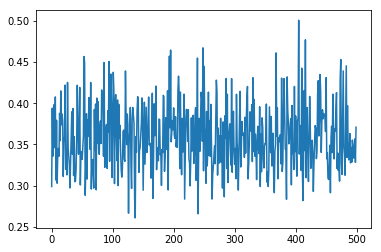

In [388]:
import matplotlib.pyplot as plt

plt.plot(eval_loss)
plt.show()

In [389]:
noise = torch.randn(tr_orig.shape[0], nz)
if cuda: 
    noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)

In [390]:
fake.shape

torch.Size([6040, 3706])

In [391]:
fake = np.around(fake.detach().cpu().numpy())

In [392]:
fake.shape

(6040, 3706)

In [393]:
np.unique(fake)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [394]:
# fake[np.where((fake <= 7).all(axis=1))[0].tolist(), :]

In [395]:
# fake = fake[np.where((fake <= 7).all(axis=1))[0].tolist(), :]

In [396]:
fake = fake * (fake <= 5).astype(int)

In [397]:
fake.shape

(6040, 3706)

In [398]:
np.unique(fake)

array([0., 1., 2., 3., 4., 5.])

In [399]:
tr = tr_orig.copy()

In [400]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 853085 185455
4 3497798 295858
3 3158746 214267
2 904104 93118
1 76932 46109
0 13893575 21474099


In [401]:
np.save('./fake', fake)

In [402]:
# fake = fake.cpu().detach().int().numpy()

In [403]:
np.unique(fake)

array([0., 1., 2., 3., 4., 5.])

In [404]:
get_sparsity(fake)

37.93144194308138

In [405]:
get_sparsity(tr+vr)

4.065990178804373

In [406]:
# np.clip(fake, 0, 5, out=fake)

In [407]:
np.unique(fake)

array([0., 1., 2., 3., 4., 5.])

In [408]:
np.save('./fake', fake)

In [409]:
rand_ix = np.random.randint(0, fake.shape[0], 300)

In [410]:
adding_fake = fake[rand_ix,:]

In [411]:
adding_fake

array([[4., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 4., 3., ..., 4., 0., 0.],
       ...,
       [0., 3., 3., ..., 4., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 4., 5., 0.]])

In [412]:
np.unique(adding_fake[:,0])

array([0., 4., 5.])

In [413]:
np.unique(fake[:,3])

array([0., 2., 3., 4.])

In [414]:
np.unique(tr[:,10])

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [415]:
get_sparsity(tr)

4.021525859265269

In [416]:
tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

reading data...
data read in 4.958484411239624 seconds
loaded dense data matrix


In [417]:
(vr == vr_1).all()

False

In [418]:
(tr[:tr_orig.shape[0], :] != tr_orig).sum()

0

In [419]:
tr_orig.shape

(6040, 3706)

In [420]:
(tr[:tr_orig.shape[0], :] == tr_orig).all()

True

In [421]:
adding_fake.shape

(300, 3706)

In [422]:
tr = np.append(tr_orig, adding_fake, axis=0)

In [423]:
get_sparsity(tr)

5.625943776057583

In [424]:
np.unique(adding_fake[:,0])

array([0., 4., 5.])

In [425]:
np.save('./fake', adding_fake)

In [426]:
to_concat = np.load('./fake.npy')

In [427]:
to_concat.astype(int)

array([[4, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 3, ..., 4, 0, 0],
       ...,
       [0, 3, 3, ..., 4, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 4, 5, 0]])

In [428]:
(adding_fake == to_concat).all()

True

In [429]:
np.unique(to_concat[:,0])

array([0., 4., 5.])

In [430]:
# seed = 47

# load data
tr_1, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,
 transpose=True, valfrac=0.1)

tm_1 = np.greater(tr_1, 1e-12).astype('float32')  # masks indicating non-zero entries
vm_1 = np.greater(vr_1, 1e-12).astype('float32')

reading data...
data read in 5.015613079071045 seconds
loaded dense data matrix


In [431]:
tr_2 = tr_1.copy()
vr_2 = vr_1.copy()

In [432]:
(vr_1 == vr_2).all(), (tr_1 == tr_2).all()

(True, True)

In [433]:
# (tr_1 == tr).all()

In [434]:
# tr_2, vr_2 = loadData('./ml-1m/ratings.dat', delimiter='::',
#                   seed=seed, transpose=False, valfrac=0.1)

In [435]:
# tr_2.shape

In [436]:
# !pip install nbimporter

In [437]:
import nbimporter 
import matrix_factorization

In [438]:
tr.shape, tr_orig.shape

((6340, 3706), (6040, 3706))

In [439]:
get_sparsity(tr)

5.625943776057583

In [440]:
get_sparsity(tr_orig)

4.021525859265269

In [441]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 3., 3., ..., 4., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 4., 5., 0.]])

In [442]:
tr_orig

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [443]:
get_sparsity(np.append(tr_orig, adding_fake, axis=0))

5.625943776057583

In [444]:
tr.shape, tr_orig.shape

((6340, 3706), (6040, 3706))

In [445]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.8297577528468786
Test mse: 0.9775390275650826
Iteration: 2
Train mse: 0.748590887837662
Test mse: 0.9036328106477802
Iteration: 5
Train mse: 0.6663414355973212
Test mse: 0.8424220862035583
Iteration: 10
Train mse: 0.6334534266636088
Test mse: 0.8227553506636661
Iteration: 25
	current iteration: 10
Train mse: 0.617686052129385
Test mse: 0.8125392294891656


In [315]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.8836162728654132
Test mse: 0.9868900094712868
Iteration: 2
Train mse: 0.8064381379616368
Test mse: 0.912432169747945
Iteration: 5
Train mse: 0.7269976741664387
Test mse: 0.8468386250023731
Iteration: 10
Train mse: 0.6918250711126741
Test mse: 0.8235196558087808
Iteration: 25
	current iteration: 10
Train mse: 0.6723376682891996
Test mse: 0.8118159487414556


In [250]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.8877403024140419
Test mse: 0.9877646311507043
Iteration: 2
Train mse: 0.8109117404701001
Test mse: 0.913184586195622
Iteration: 5
Train mse: 0.7324932553664418
Test mse: 0.8475710442911681
Iteration: 10
Train mse: 0.6981602761542449
Test mse: 0.8243449457302674
Iteration: 25
	current iteration: 10
Train mse: 0.6789824303631368
Test mse: 0.8126721986635405


In [184]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.8984780320969817
Test mse: 0.9881095400254272
Iteration: 2
Train mse: 0.8226084974770077
Test mse: 0.9138558038837877
Iteration: 5
Train mse: 0.7457315999708153
Test mse: 0.8487378397661497
Iteration: 10
Train mse: 0.7124193355040122
Test mse: 0.8257099963841487
Iteration: 25
	current iteration: 10
Train mse: 0.6935184540376451
Test mse: 0.8141629708875354


In [106]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.9305347546154136
Test mse: 0.9921757785323428
Iteration: 2
Train mse: 0.856695009237703
Test mse: 0.9181283703366954
Iteration: 5
Train mse: 0.7840446399021312
Test mse: 0.853764585187775
Iteration: 10
Train mse: 0.7540869301984444
Test mse: 0.8314347369690854
Iteration: 25
	current iteration: 10
Train mse: 0.7368852800185531
Test mse: 0.8203492654314485


In [380]:
MF_SGD = matrix_factorization.ExplicitMF(tr_orig, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 1.0081221649490966
Test mse: 1.0065790926457936
Iteration: 2
Train mse: 0.9351036902876875
Test mse: 0.9335066480326242
Iteration: 5
Train mse: 0.8641363109860711
Test mse: 0.8631726972942693
Iteration: 10
Train mse: 0.8319570864115803
Test mse: 0.8316635113258415
Iteration: 25
	current iteration: 10
Train mse: 0.8090816725918839
Test mse: 0.8099217632916137


In [109]:
MF_SGD = matrix_factorization.ExplicitMF(tr_orig, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [50]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 50
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7596166950039378
Test mse: 0.7638189405418305


In [251]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [50]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 50


KeyboardInterrupt: 

In [185]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='als', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [40]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 40
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
Train mse: 5.539027135789662
Test mse: 5.798524746250075


In [381]:
MF_SGD = matrix_factorization.ExplicitMF(np.append(tr_orig, adding_fake, axis=0), 40, learning='als', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [200]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
Train mse: 5.432149262874834
Test mse: 5.847738325764118


In [382]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='als', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [200]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
Train mse: 5.432143338931888
Test mse: 5.847738347913168


In [ ]:
tr_orig

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(np.append(tr_orig, adding_fake, axis=0), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [20]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
tr.shape, tr_orig.shape

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_orig, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [40]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
tr.shape

In [ ]:
tr_2 = np.append(tr, to_concat[:2000,:], axis=0)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_2, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

iter_array = [10]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
tm = np.greater(tr, 1e-12).astype('float32')  # masks indicating non-zero entries
tm_orig = np.greater(tr_orig, 1e-12).astype('float32')
vm = np.greater(vr, 1e-12).astype('float32')

n_m = tr.shape[0]  # number of movies
n_u = tr.shape[1]  # number of users (may be switched depending on 'transpose' in loadData)

# Set hyper-parameters
n_hid = 500
# lambda_2 = float(sys.argv[1]) if len(sys.argv) > 1 else 60.
# lambda_s = float(sys.argv[2]) if len(sys.argv) > 2 else 0.013
n_layers = 2
output_every = 50  # evaluate performance on test set; breaks l-bfgs loop
n_epoch = n_layers * 10 * output_every
verbose_bfgs = True
use_gpu = True

In [ ]:
if not use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    
# Input placeholders
R = tf.placeholder("float", [None, n_u])

In [ ]:
# define network functions
def kernel(u, v):
    """
    Sparsifying kernel function

    :param u: input vectors [n_in, 1, n_dim]
    :param v: output vectors [1, n_hid, n_dim]
    :return: input to output connection matrix
    """
    dist = tf.norm(u - v, ord=2, axis=2)
    hat = tf.maximum(0., 1. - dist**2)
    return hat


def kernel_layer(x, n_hid=500, n_dim=5, activation=tf.nn.sigmoid, name=''):
    """
    a kernel sparsified layer

    :param x: input [batch, channels]
    :param n_hid: number of hidden units
    :param n_dim: number of dimensions to embed for kernelization
    :param activation: output activation
    :param name: layer name for scoping
    :return: layer output, regularization term
    """

    # define variables
    with tf.variable_scope(name):
        W = tf.get_variable('W', [x.shape[1], n_hid])
        n_in = x.get_shape().as_list()[1]
        u = tf.get_variable('u', initializer=tf.random.truncated_normal([n_in, 1, n_dim], 0., 1e-3))
        v = tf.get_variable('v', initializer=tf.random.truncated_normal([1, n_hid, n_dim], 0., 1e-3))
        b = tf.get_variable('b', [n_hid])

    # compute sparsifying kernel
    # as u and v move further from each other for some given pair of neurons, their connection
    # decreases in strength and eventually goes to zero.
    w_hat = kernel(u, v)

    # compute regularization terms
#     sparse_reg = tf.contrib.layers.l2_regularizer(lambda_s)
    sparse_reg_term = tf.contrib.layers.apply_regularization(sparse_reg, [w_hat])

    l2_reg = tf.contrib.layers.l2_regularizer(lambda_2)
    l2_reg_term = tf.contrib.layers.apply_regularization(l2_reg, [W])

    # compute output
    W_eff = W * w_hat
    y = tf.matmul(x, W_eff) + b
    y = activation(y)
    return y, sparse_reg_term + l2_reg_term


# Instantiate network
y = R
reg_losses = None
for i in range(n_layers):
    y, reg_loss = kernel_layer(y, n_hid, name=str(i))
    reg_losses = reg_loss if reg_losses is None else reg_losses + reg_loss
prediction, reg_loss = kernel_layer(y, n_u, activation=tf.identity, name='out')
reg_losses = reg_losses + reg_loss

# Compute loss (symbolic)
diff = tm*(R - prediction)
sqE = tf.nn.l2_loss(diff)
loss = sqE + reg_losses

# Instantiate L-BFGS Optimizer
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': output_every,
                                                                  'disp': verbose_bfgs,
                                                                  'maxcor': 10},
                                                   method='L-BFGS-B')

In [ ]:
# Training and validation loop
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(int(n_epoch / output_every)):
        optimizer.minimize(sess, feed_dict={R: tr}) #do maxiter optimization steps
        pre = sess.run(prediction, feed_dict={R: tr}) #predict ratings

        error = (vm * (np.clip(pre, 1., 5.) - vr) ** 2).sum() / vm.sum() #compute validation error
        error_train = (tm * (np.clip(pre, 1., 5.) - tr) ** 2).sum() / tm.sum() #compute train error
        error_train_orig = (tm_orig * (np.clip(pre, 1., 5.) - tr_orig) ** 2).sum() / tm_orig.sum() #compute train error

        print('.-^-._' * 12)
        print('epoch:', i, 'validation rmse:', np.sqrt(error), 'train rmse:', np.sqrt(error_train), 'train orig rmse:', np.sqrt(error_train_orig))
        print('.-^-._' * 12)

    with open('summary_ml1m.txt', 'a') as file:
        for a in sys.argv[1:]:
            file.write(a + ' ')
        file.write(str(np.sqrt(error)) + ' ' + str(np.sqrt(error_train), + ' ' + str(np.sqrt(error_train))
                   + ' ' + str(seed) + '\n')
        file.close()